# Predicting Confidence Intervals

We will go over the basics of using the BaseErrorModel class for predicting confidence intervals, including both basic and more sophisticated predictors.

In [1]:
import olorenchemengine as oce
import pandas as pd
import numpy as np
import json
import tqdm

import matplotlib.pyplot as plt
from scipy.stats import linregress

import os

if not os.path.exists("lipophilicity_dataset.oce"):
    dataset = oce.DatasetFromCSV("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv", structure_col = "smiles", property_col = "exp")
    splitter = oce.RandomSplit(split_proportions=[0.8,0.1,0.1])
    dataset = dataset + splitter
    oce.save(dataset, 'lipophilicity_dataset.oce')
else:
    dataset = oce.load('lipophilicity_dataset.oce')

if not os.path.exists("lipophilicity_model_rf.oce"):
    model = oce.RandomForestModel(oce.OlorenCheckpoint("default"), n_estimators=1000)
    model.fit(dataset.train_dataset[0], dataset.train_dataset[1])
    oce.save(model, 'lipophilicity_model_rf.oce')
else:
    model = oce.load("lipophilicity_model_rf.oce")

## SDC

We will demonstrate the basics of the class with SDC. We start by creating an instance of the SDC class with our trained model and the dataset used for training.

In [2]:
testSDC = oce.SDC()
testSDC.build(model, dataset.train_dataset[0], dataset.train_dataset[1])

We can now fit the estimator with a dataset used for validation. Fitting our estimator will display a graph of the residual versus the confidence score. The graph can be turned off by setting ```plot = False```. Blue points are our validation datapoints, red points are the confidence intervals for each bin, and the red line is the fitted linear model. 

100%|██████████| 420/420 [00:02<00:00, 184.87it/s]


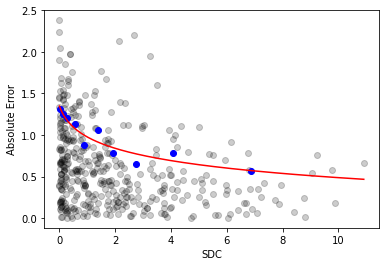

In [3]:
testSDC.fit(dataset.valid_dataset[0], dataset.valid_dataset[1], ci = 0.8)

We can also fit the estimator by running cross validation on the training dataset.

100%|██████████| 672/672 [00:02<00:00, 224.88it/s]


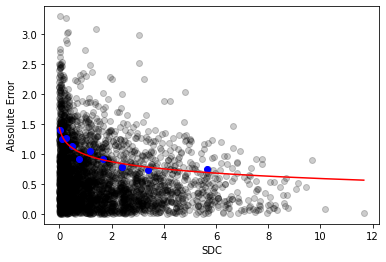

In [4]:
testSDC.fit_cv(dataset.train_dataset[0], dataset.train_dataset[1], ci = 0.8)

Finally, we can predict confidence interval widths for any input, including the test data of the original dataset.

In [5]:
testSDC.score(dataset.test_dataset[0])

100%|██████████| 420/420 [00:02<00:00, 186.19it/s]


array([0.66914922, 1.24728655, 1.11637354, 1.21229986, 1.27785821,
       1.02001224, 1.12832667, 0.68305162, 0.78010409, 0.88680458,
       0.75352233, 1.40190335, 0.82108541, 0.81875341, 0.94971502,
       0.92184447, 0.7085611 , 0.9527132 , 1.27224363, 0.67239141,
       0.99290262, 0.97082704, 0.8346686 , 0.75820479, 0.95387125,
       1.00412148, 0.90690157, 0.79748698, 0.8709039 , 0.81809214,
       1.3026172 , 0.66257439, 1.35828093, 1.13880351, 1.10103394,
       1.34147709, 1.13895378, 1.11782627, 0.79257195, 1.43756709,
       1.24048287, 0.80213636, 1.23748013, 0.91543896, 0.82693261,
       1.11471099, 1.19992682, 1.24033785, 1.06337753, 0.87407077,
       1.11394913, 0.92488618, 0.81789113, 0.87516252, 1.04546787,
       1.28196584, 0.81461337, 0.73354049, 0.72968498, 1.23430986,
       0.70614422, 1.2731069 , 0.74411269, 1.12943688, 0.76355617,
       1.39781028, 0.70865706, 0.85593228, 0.90489395, 0.8224375 ,
       1.14110677, 0.81390605, 0.80894065, 1.4270572 , 0.91740

These can be visualized as well

## ADAN

ADAN is a model with six different parameters from Applicability Domain Analysis (ADAN): A
Robust Method for Assessing the Reliability of Drug Property Predictions
<https://doi.org/10.1021/ci500172z>. We will now demonstrate running the ADAN model with the BaseErrorModel class. Like before, we start by creating the ADAN object.

In [6]:
testADAN = oce.ADAN('D_raw', method = 'bin')
testADAN.build(model, dataset.train_dataset[0], dataset.train_dataset[1])

Fitting the model is the same except for the input of the ADAN criteria we wish to use. The argument for ```ADAN```  is the ADAN criteria which must be assigned to a subset of ```['A','B','C','D','E','F','A_raw','B_raw','C_raw','D_raw','E_raw','F_raw']```. Raw values are standardized based on the testing data.

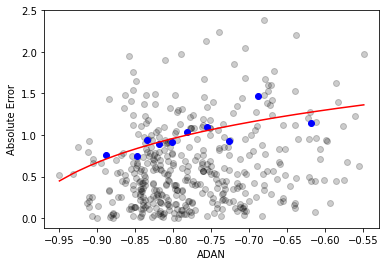

In [8]:
testADAN.fit(dataset.valid_dataset[0], dataset.valid_dataset[1], ci=0.8)

Predicting confidence scores is the same as before.

In [9]:
testADAN.score(dataset.test_dataset[0])

array([1.07229305, 1.06317667, 1.2776068 , 0.97450297, 1.10666749,
       0.96477073, 0.77205731, 1.23532857, 0.72553516, 0.63110914,
       0.79225106, 0.87920877, 0.91504868, 0.75215754, 0.98747567,
       0.84893132, 0.85047732, 1.20382405, 1.03598142, 1.02107276,
       0.69342059, 1.08850223, 1.04295368, 0.90088362, 0.90182826,
       1.05642099, 0.87998811, 0.98239468, 0.88960256, 1.08373314,
       1.23980104, 1.03097509, 0.82863321, 0.80703764, 0.89466226,
       0.96581247, 1.06812263, 1.1328466 , 1.03844711, 1.12824653,
       1.09908256, 0.91547667, 0.95495313, 1.20075351, 1.12264256,
       1.30712858, 1.26187042, 0.97527126, 0.86337809, 0.90637877,
       1.29684809, 1.08706449, 0.95011976, 0.89257958, 1.02651223,
       1.01328341, 1.02980758, 0.96335242, 0.66250202, 0.96654971,
       1.14899116, 1.081156  , 0.66411388, 1.03683158, 0.8985939 ,
       1.07531892, 1.12620975, 1.04761067, 0.7823963 , 1.18077958,
       1.06257411, 0.88469559, 0.83166334, 1.1790137 , 0.89204

## Analysis

We can analyze what fraction of the test data is within is predicted confidence interval. If our datasets were chosen properly, that fraction should be very similar to the confidence interval we chose during fitting (0.8). We can also compare the predicted confidence intervals to the confidence intervals calculated given the standard deviation of the validation dataset.

In [10]:
in_interval = np.abs(dataset.test_dataset[1] - model.predict(dataset.test_dataset[0]['smiles'])) < testSDC.score(dataset.test_dataset[0])

100%|██████████| 420/420 [00:02<00:00, 186.95it/s]


In [11]:
sum(in_interval) / len(in_interval)

0.8